# BEE 4750 Environmental Systems Analysis

# [Cornell Class Roster API](https://classes.cornell.edu/content/SP22/api-details)

config/rosters - Available rosters.
- No parameters

config/acadCareers - Available academic careers for a roster.
- Requires roster= < slug >

config/acadGroups - Available academic groups for a roster.
- Requires roster= < slug >

config/classLevels - Available class levels for a roster.
- Requires roster= < slug >

config/subjects - Available subjects for roster.
- Requires roster= < slug >

search/classes - Scheduled classes, including Course of Study details.
- Requires roster= < slug > and subject= < subject >
- Optionally: 
    
    acadGroup[]= < academic-group >, 

    acadCareer[]= < academic-career >, 

    classLevels[]= < class-levels >, 

    crseAttrs[]= < course-attribute >, 

    instructMode[]= < instruction-mode >, 

    q= < searchTerm >

# Intializing & Importing Data

In [1]:
import Pkg
Pkg.add("HTTP")
Pkg.add("JSON")
Pkg.add("Plots")
Pkg.add("Colors")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("DataStructures")
Pkg.add("Distributions")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [2]:
using HTTP
using JSON
using Plots
using Colors
using CSV
using DataFrames
using DataStructures
using Distributions

In [3]:
function importRoomSizes()
    # The CSV is read into a DataFrame object, and we specify that it is comma delimited
    LocationList = CSV.read("SpListingExcel_LocationList.csv", DataFrame, delim=",")
    roomNameList = LocationList[!, "Location Name"]
    roomSizeList = LocationList[!, "Default Layout Capacity"]
    return sort(Dict(roomNameList .=> roomSizeList))
end
room_size_dict = importRoomSizes();

In [4]:
function importRoomLocation()
    LocationList = CSV.read("SpListingExcel_LocationList.csv", DataFrame, delim=",")
    roomNameList = LocationList[!, "Location Name"]
    roomLatitudeList = LocationList[!, "Latitude"]
    roomLongitudeList = LocationList[!, "Longitude"]
    roomLocationList = [(x, y) for (x, y) in zip(roomLatitudeList, roomLongitudeList)]
    roomNameList = [s[1:3] for s in roomNameList]
    return sort(Dict(roomNameList .=> roomLocationList))
end
room_location_dict = importRoomLocation();

In [5]:
# Import building names and codes as dictionaries
function importBuildingCodes()
    # Specify the path to the text document
    file_path = "Cornell_Registrar_Building_Codes.txt"

    # Open the file in read mode
    file = open(file_path, "r")

    # Read the contents of the file into a string
    building_code_name = read(file, String)

    # Close the file
    close(file)

    # Split the string into words using the \n delimiter
    words = split(building_code_name, "\n")

    # Initialize arrays for even and odd-indexed words
    building_name = String[]
    building_code = String[]

    # Iterate through the words and separate them into even and odd arrays
    for (index, word) in enumerate(words)
        if iseven(index)
            push!(building_name, word)
        else
            push!(building_code, word)
        end
    end

    # Initialize an empty dictionary
    building_name_dict = Dict{String,String}()
    building_code_dict = Dict{String,String}()

    # Iterate through both arrays and populate the dictionary
    for (name, code) in zip(building_name, building_code)
        building_name_dict[name] = code
    end

    # Iterate through the dictionary and swap names and codes
    for (key, value) in building_name_dict
        building_code_dict[value] = key
    end

    return sort(building_name_dict), sort(building_code_dict)
end
building_name_all_dict, building_code_all_dict = importBuildingCodes();

In [6]:
function API_data(endpoint;
    base_url="https://classes.cornell.edu/api/2.0/",
    roster_slug="FA23", # always required
    subject_slug="",
    acadCareer_slug="",
    acadGroups_slug="",
    classLevels_slug="",
    crseAttrs_search_slug="",
    instructMode_search_slug="",
    q_search_slug="")

    # Pick one endpoint only
    #endpoint = "config/rosters.json" # JSON response
    #endpoint = "config/acadCareers.json" # JSON response
    #endpoint = "config/acadGroups.json" # JSON response
    #endpoint = "config/classLevels.json" # JSON response
    #endpoint = "config/subjects.json" # JSON response
    #endpoint = "search/classes.json" # JSON response

    data = []

    # Construct the full API URL (only inlcude nonempty slugs)
    api_url =
        "$base_url$endpoint" *
        "?roster=$roster_slug" *
        (any(isempty.(subject_slug)) ? "" : "&subject=$subject_slug") *
        (any(isempty.(acadCareer_slug)) ? "" : "&acadCareers[]=$acadCareer_slug") *
        (any(isempty.(acadGroups_slug)) ? "" : "&acadGroups[]=$acadGroups_slug") *
        (any(isempty.(classLevels_slug)) ? "" : "&classLevels[]=$classLevels_slug") *
        (any(isempty.(crseAttrs_search_slug)) ? "" : "&crseAttrs[]=$crseAttrs_search_slug") *
        (any(isempty.(instructMode_search_slug)) ? "" : "&instructMode[]=$instructMode_search_slug") *
        (any(isempty.(q_search_slug)) ? "" : "&q=$q_search_slug")
    #display(api_url)

    # Make an HTTP GET request to the API
    response = HTTP.get(api_url)

    # Check if the request was successful
    if response.status == 200
        # Assuming the response is in JSON format
        data = JSON.parse(String(response.body))
        #display(data)
        #println(data)
    else
        println("Request failed with status code $(response.status)")
    end
    return data
end

API_data (generic function with 1 method)

In [7]:
function segregate_days(input_string)
    days = ["M", "T", "W", "R", "F", "S", "Su"]

    day_dict = Dict{String,String}()

    i = 1
    while i <= length(input_string)
        char = input_string[i]

        if i < length(input_string) && char == 'S' && input_string[i+1] == 'u'
            # If 'S' is followed by 'u', consider "Su" as a day
            day = "Su"
            i += 1  # Move the index one step further
        else
            day = string(char)
        end

        # Check if the day is one of the recognized days
        if day in days
            if haskey(day_dict, day)
                day_dict[day] *= day  # Append to the day string
            else
                day_dict[day] = day  # Create a new day string
            end
        end

        i += 1  # Move to the next character
    end

    return collect(values(day_dict))
end

segregate_days (generic function with 1 method)

In [8]:
function importBusStops()
    # The CSV is read into a DataFrame object, and we specify that it is comma delimited
    busStopList = CSV.read("BEE 4750 - locations of cornell campus - Building to Stop.csv", DataFrame, delim=",")
    buildingList = busStopList[!, "building"]
    stopList = busStopList[!, "bus stop"]
    walkingList = busStopList[!, "walking time (minutes)"]
    return sort(Dict(buildingList .=> stopList)), sort(Dict(buildingList .=> walkingList))
end
building_stop_dict, building_walkTime_dict = importBusStops();

# Gather API Data

In [9]:
# Codes in class roster that are not buildings: 25L, TBA, Onl
#   25L: Classes that are expected to be scheduled using the central 
#       scheduling system must have a Facility ID code of “25L” indicated 
#       in the Course/Class Interface (CCI).
#   TBA: To Be Assigned
#   Onl: Online Meetings

endpoint = "config/subjects.json" # JSON response
subjects = API_data(endpoint)

# Initialize with empty arrays as values
subject_name_dict = Dict{String,String}()
subject_code_dict = Dict{String,String}()
building_class_dict = Dict{String,Vector{Dict{String,Any}}}()
room_class_dict = Dict{String,Vector{Dict{String,Any}}}()
days_dict = Dict("M" => "Monday",
    "T" => "Tuesday",
    "W" => "Wednesday",
    "R" => "Thursday",
    "F" => "Friday",
    "S" => "Saturday",
    "Su" => "Sunday")
day_timeStart_room_dict = Dict{String,Dict{String,Vector{Any}}}(day => Dict{String,Vector{Any}}() for day in keys(days_dict))
day_timeEnd_room_dict = Dict{String,Dict{String,Vector{Any}}}(day => Dict{String,Vector{Any}}() for day in keys(days_dict))
classes = []
endpoint = "search/classes.json" # JSON response
for subject in subjects["data"]["subjects"]
    subject_name_dict[subject["descrformal"]] = subject["value"]
    subject_code_dict[subject["value"]] = subject["descrformal"]
    classes = API_data(endpoint, subject_slug=subject["value"])
    for class in (classes["data"]["classes"]) # Vector
        #class_title = join([class["subject"], " ", class["catalogNbr"]])
        for group in class["enrollGroups"] # Dict
            for session in group["classSections"] # Dict
                for meetings in session["meetings"] # Dict

                    if haskey(meetings, "facilityDescrshort") &&
                       meetings["facilityDescrshort"] !== nothing &&
                       haskey(room_size_dict, meetings["facilityDescrshort"])

                        room = meetings["facilityDescrshort"]
                        code = room[1:3]

                        if (!haskey(building_class_dict, code) &&
                            haskey(building_code_all_dict, code)) ||
                           (haskey(building_class_dict, code) &&
                            !(meetings in building_class_dict[code]))

                            ################################################
                            # Segrates all meetings into buildings
                            if haskey(building_class_dict, code)
                                push!(building_class_dict[code], meetings)
                            else
                                building_class_dict[code] = [meetings]
                            end
                            ################################################

                            ################################################
                            if haskey(room_class_dict, room)
                                push!(room_class_dict[room], class)
                            else
                                room_class_dict[room] = [class]
                            end
                            ################################################

                            ################################################
                            if !isempty(meetings["timeStart"])
                                meetingDays = segregate_days(string(meetings["pattern"]))
                                for day in meetingDays
                                    day = string(day)
                                    if !haskey(day_timeStart_room_dict, day)
                                        day_timeStart_room_dict[day] = Dict{String,Vector{String}}()
                                    end

                                    if haskey(day_timeStart_room_dict[day], meetings["timeStart"])
                                        push!(day_timeStart_room_dict[day][meetings["timeStart"]], room)
                                    else
                                        day_timeStart_room_dict[day][meetings["timeStart"]] = [room]
                                    end

                                    for dict_day in keys(day_timeStart_room_dict)
                                        if !haskey(day_timeStart_room_dict[dict_day], meetings["timeStart"])
                                            day_timeStart_room_dict[dict_day][meetings["timeStart"]] = []
                                        end

                                        if !haskey(day_timeStart_room_dict[dict_day], meetings["timeEnd"])
                                            day_timeStart_room_dict[dict_day][meetings["timeEnd"]] = []
                                        end
                                    end
                                end
                            end
                            ################################################

                            ################################################
                            if !isempty(meetings["timeEnd"])
                                meetingDays = segregate_days(string(meetings["pattern"]))
                                for day in meetingDays
                                    day = string(day)
                                    if !haskey(day_timeEnd_room_dict, day)
                                        day_timeEnd_room_dict[day] = Dict{String,Vector{String}}()
                                    end

                                    if haskey(day_timeEnd_room_dict[day], meetings["timeEnd"])
                                        push!(day_timeEnd_room_dict[day][meetings["timeEnd"]], room)
                                    else
                                        day_timeEnd_room_dict[day][meetings["timeEnd"]] = [room]
                                    end

                                    for dict_day in keys(day_timeEnd_room_dict)
                                        if !haskey(day_timeEnd_room_dict[dict_day], meetings["timeEnd"])
                                            day_timeEnd_room_dict[dict_day][meetings["timeEnd"]] = []
                                        end

                                        if !haskey(day_timeEnd_room_dict[dict_day], meetings["timeStart"])
                                            day_timeEnd_room_dict[dict_day][meetings["timeStart"]] = []
                                        end
                                    end
                                end
                            end
                            ################################################

                        end
                    end
                end
            end
        end
    end
end

# Sorting

### Functions

In [10]:
function custom_time_sort(time_str)
    # Extract the hour and minute components
    hour, minute = parse(Int, time_str[1:2]), parse(Int, time_str[4:5])

    # Adjust for PM times
    if contains(time_str, "PM") && hour != 12
        hour += 12
    end

    # Calculate the total minutes since midnight
    total_minutes = hour * 60 + minute

    return total_minutes
end

custom_time_sort (generic function with 1 method)

In [11]:
function custom_day_sort(day)
    days_sort = Dict("M" => 1, "T" => 2, "W" => 3, "R" => 4, "F" => 5, "S" => 6, "Su" => 7)
    return days_sort[day]
end

custom_day_sort (generic function with 1 method)

### Sorting Arrays

In [12]:
subject_name_dict = sort(subject_name_dict)
subject_code_dict = sort(subject_code_dict)

building_class_dict = sort(building_class_dict)
room_class_dict = sort(room_class_dict)

day_timeStart_room_dict = sort(day_timeStart_room_dict, by=custom_day_sort)
day_timeEnd_room_dict = sort(day_timeEnd_room_dict, by=custom_day_sort)

time_array = sort(collect(keys(day_timeStart_room_dict["M"])), by=custom_time_sort);

In [13]:
building_code_dict = Dict{String,String}()
for building in keys(building_class_dict)
    building_code_dict[building] = building_code_all_dict[building]
end

### Time array

In [14]:
function changeTime(time, increment)
    hour = time[1:2]
    colon = time[3]
    minutes = time[4:5]
    ampm = time[6:7]
    minutesInt = parse(Int, minutes)
    hourInt = parse(Int, hour)

    # switch to 24-hour time
    if ampm == "AM"
        if hourInt == 12
            hourInt = hourInt - 12
        end
    elseif ampm == "PM"
        if hourInt != 12
            hourInt = (hourInt + 12)
        end
    end
    hourInt = hourInt % 24

    # convert time to minutes from midnight (00:00)
    hourMin = hourInt * 60
    totalMin = minutesInt + hourMin

    # add increment
    h = totalMin + increment

    # convert back to hours and minutes (24-hour time)
    hr = floor((h) / 60)
    min = h - (hr * 60)
    if hr < 0
        hr = 24 + hr
    end

    # convert to 12-hour time
    if hr > 11
        ampm = "PM"
        if hr != 12
            hr = hr - 12
        end
    elseif hr == 0
        ampm = "AM"
        hr = 12
    end

    # format to string
    minString = string(Int(min))
    hrString = string(Int(hr))
    if min < 10
        minString = join([string(0), minString])
    end
    if hr < 10
        hrString = join([string(0), hrString])
    end
    new_time = join([hrString, ":", minString, ampm])
    return new_time
end

changeTime (generic function with 1 method)

In [15]:
function arrayTime(startTime, endTime)
    arrayTime = []
    time = startTime
    push!(arrayTime, time)
    while endTime != time
        #println(time)
        time = changeTime(time, 1)
        push!(arrayTime, time)
    end
    #println(arrayTime)
    return arrayTime
end

arrayTime (generic function with 1 method)

In [16]:
time_first = time_array[1]
time_last = time_array[end]
time_array_full = arrayTime(time_first, time_last)

971-element Vector{Any}:
 "06:20AM"
 "06:21AM"
 "06:22AM"
 "06:23AM"
 "06:24AM"
 "06:25AM"
 "06:26AM"
 "06:27AM"
 "06:28AM"
 "06:29AM"
 ⋮
 "10:22PM"
 "10:23PM"
 "10:24PM"
 "10:25PM"
 "10:26PM"
 "10:27PM"
 "10:28PM"
 "10:29PM"
 "10:30PM"

In [17]:
for day in keys(day_timeStart_room_dict)
    for t in time_array_full
        if !(t in collect(keys(day_timeStart_room_dict[day])))
            day_timeStart_room_dict[day][t] = []
        end
        if !(t in collect(keys(day_timeEnd_room_dict[day])))
            day_timeEnd_room_dict[day][t] = []
        end
    end
end

# Plotting


|**Name** | **Description** |
|:-------:|:---------------:|
| y_students_building | Amount of students in a building vs time |
| y_students_building_change | Change of students in a building vs time |

### Students

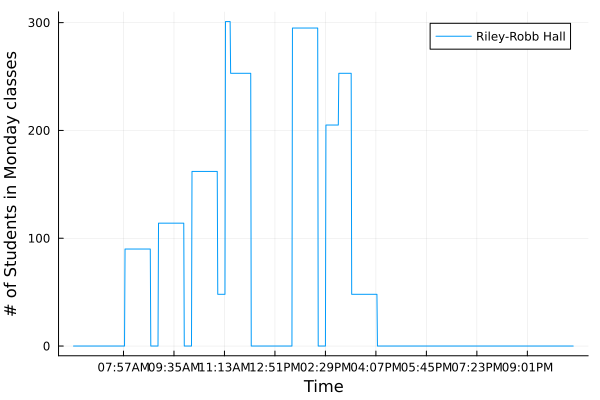

In [18]:
y_students_building = OrderedDict{String,OrderedDict{String,Vector{Any}}}()
#[day][room](time)
for day in keys(days_dict)
    y_students_building[day] = OrderedDict{String,Vector{Any}}()
    for room in keys(room_class_dict) # get rooms
        building = room[1:3]
        if !haskey(y_students_building[day], building)
            y_students_building[day][building] = zeros(length(time_array_full))
        end
        room_time_vector = []
        num_room_inSession = 0
        num_students_inSession_building = 0
        for time in time_array_full
            num_room_start = length([str for str in day_timeStart_room_dict[day][time] if occursin(room, str)])
            num_room_end = length([str for str in day_timeEnd_room_dict[day][time] if occursin(room, str)])

            num_room_inSession = num_room_inSession +
                                 num_room_start -
                                 num_room_end
            push!(room_time_vector, num_room_inSession * room_size_dict[room])
        end
        y_students_building[day][building] = y_students_building[day][building] + room_time_vector
    end
end
y_students_building = sort(y_students_building, by=custom_day_sort)

day = "M"
building = "RRB"
plot(time_array_full, y_students_building[day][building], xlabel="Time", ylabel="# of Students in $(days_dict[day]) classes", label=building_code_dict[building])

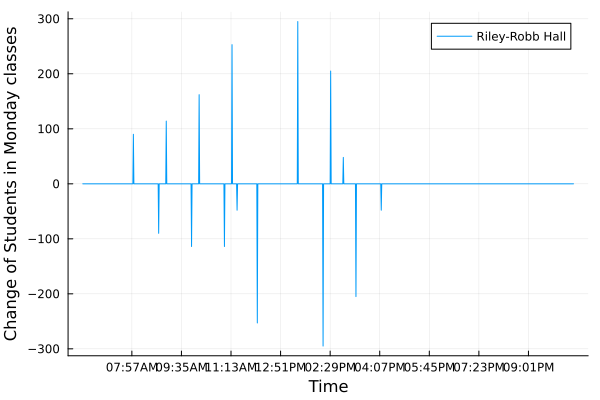

In [19]:
y_students_building_change = OrderedDict{String,OrderedDict{String,Vector{Any}}}()
#[day][room](time)
for day in keys(days_dict)
    y_students_building_change[day] = OrderedDict{String,Vector{Any}}()
    for building in keys(building_class_dict) # get buildings
        y_students_building_change[day][building] = []
        t_prev = 0
        for t in 1:length(time_array_full)
            t_now = y_students_building[day][building][t]
            push!(y_students_building_change[day][building], t_now - t_prev)
            t_prev = t_now
        end
    end
end
y_students_building_change = sort(y_students_building_change, by=custom_day_sort)

day = "M"
building = "RRB"
plot(time_array_full, y_students_building_change[day][building], xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

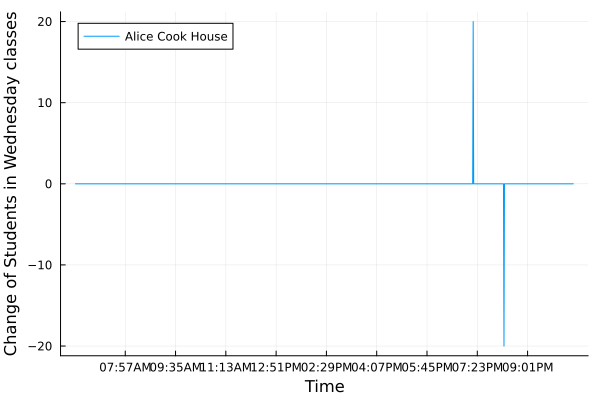

In [20]:
day = "W"
building = "ACH"
plot(time_array_full, y_students_building_change[day][building], xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

In [21]:
# change y_students_building_change where the time is a dictionary, instead of a vector
y_students_building_change_Dict = OrderedDict{String,OrderedDict{String,OrderedDict{String,Int64}}}()
for day in keys(days_dict)
    y_students_building_change_Dict[day] = OrderedDict{String,OrderedDict{String,Int64}}()
    for building in keys(building_class_dict) # get buildings
        y_students_building_change_Dict[day][building] = OrderedDict{String,Int64}()
        for (i, t) in enumerate(time_array_full)
            y_students_building_change_Dict[day][building][t] = y_students_building_change[day][building][i]
        end
    end
end

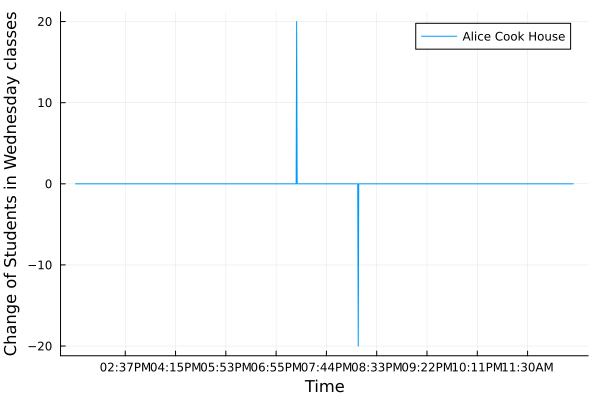

In [22]:
day = "W"
building = "ACH"
plot(y_students_building_change_Dict[day][building], xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

In [23]:
# shift over class times to make it about bus stop walking distance
y_students_building_change_busShifted_Dict = OrderedDict{String,OrderedDict{String,OrderedDict{String,Int64}}}()
time_array_shifted = []
for day in keys(y_students_building_change_Dict)
    y_students_building_change_busShifted_Dict[day] = OrderedDict{String,OrderedDict{String,Int64}}()
    for building in keys(y_students_building_change_Dict[day])
        y_students_building_change_busShifted_Dict[day][building] = OrderedDict{String,Int64}()
        building_long = building_code_dict[building]
        walkingTime_min = building_walkTime_dict[building_long]
        if walkingTime_min != 0
            for time in time_array_full
                value = y_students_building_change_Dict[day][building][time]
                if value > 0
                    # class is starting
                    shifted_time = changeTime(time, -walkingTime_min)
                    y_students_building_change_busShifted_Dict[day][building][shifted_time] = value
                if !(shifted_time in time_array_shifted)
                    push!(time_array_shifted, shifted_time)
                end
                elseif value < 0
                    # class is ending
                    shifted_time = changeTime(time, walkingTime_min)
                    y_students_building_change_busShifted_Dict[day][building][shifted_time] = value
                if !(shifted_time in time_array_shifted)
                    push!(time_array_shifted, shifted_time)
                end
                elseif !(haskey(y_students_building_change_busShifted_Dict[day][building], time))
                    shifted_time = time
                    y_students_building_change_busShifted_Dict[day][building][shifted_time] = value
                if !(shifted_time in time_array_shifted)
                    push!(time_array_shifted, shifted_time)
                end
                end
                
            end
        end
    end
end
time_array_shifted = sort(time_array_shifted, by=custom_time_sort)
y_students_building_change_busShifted_Dict = sort(y_students_building_change_busShifted_Dict, by=custom_day_sort);

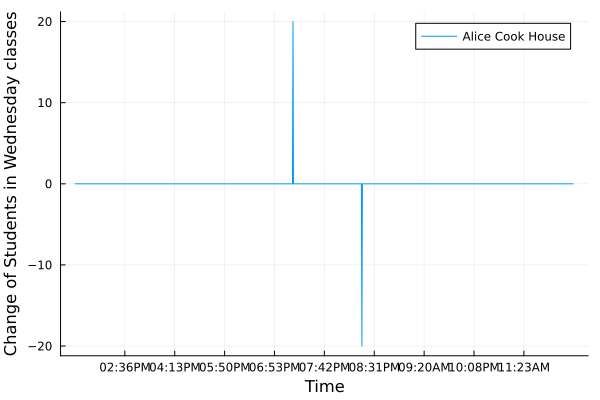

In [24]:
day = "W"
building = "ACH"
plot(y_students_building_change_busShifted_Dict[day][building], xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

In [25]:
time_first_shifted = time_array_shifted[1]
time_last_shifted = time_array_shifted[end]
time_array_full_shifted = arrayTime(time_first_shifted, time_last_shifted)

979-element Vector{Any}:
 "06:17AM"
 "06:18AM"
 "06:19AM"
 "06:20AM"
 "06:21AM"
 "06:22AM"
 "06:23AM"
 "06:24AM"
 "06:25AM"
 "06:26AM"
 ⋮
 "10:27PM"
 "10:28PM"
 "10:29PM"
 "10:30PM"
 "10:31PM"
 "10:32PM"
 "10:33PM"
 "10:34PM"
 "10:35PM"

In [26]:
y_students_building_change_busShifted_Dict_sameTimes = OrderedDict{String,OrderedDict{String,OrderedDict{String,Int64}}}()
for day in keys(y_students_building_change_busShifted_Dict)
    y_students_building_change_busShifted_Dict_sameTimes[day] = OrderedDict{String,OrderedDict{String,Int64}}()
    for building in keys(y_students_building_change_busShifted_Dict[day])
        y_students_building_change_busShifted_Dict_sameTimes[day][building] = OrderedDict{String,Int64}(time_array_full_shifted .=> 0)
        for time in time_array_full_shifted
            if !(haskey(y_students_building_change_busShifted_Dict[day][building], time))
                y_students_building_change_busShifted_Dict_sameTimes[day][building][time] = 0
            else
                y_students_building_change_busShifted_Dict_sameTimes[day][building][time] = y_students_building_change_busShifted_Dict[day][building][time]
            end
        end
    end
end

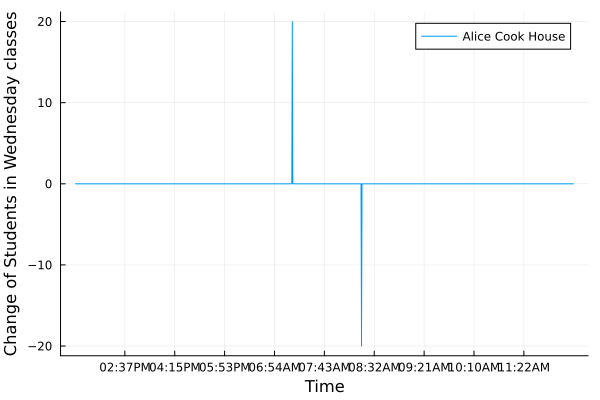

In [27]:
day = "W"
building = "ACH"
plot(y_students_building_change_busShifted_Dict_sameTimes[day][building], xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

# Distributions

In [28]:
function generate_gaussian_distribution(mean, std, total_people, time_points)
    # Create a Gaussian distribution
    distribution = Normal(mean, std)

    # Generate time points and corresponding number of people using the Gaussian distribution
    time_values = collect(1.0:time_points)
    people_flow = total_people * pdf.(distribution, time_values)
    return time_values, people_flow
end

generate_gaussian_distribution (generic function with 1 method)

In [29]:
function generate_exponential_distribution(mean, total_people, time_points)
    distribution = Exponential(mean)
    time_values = collect(1:time_points)
    people_flow = total_people * pdf.(distribution, time_values)
    return time_values, people_flow
end

generate_exponential_distribution (generic function with 1 method)

In [30]:
function generate_poisson_distribution(mean, total_people, time_points)
    distribution = Poisson(mean)
    time_values = collect(1:time_points)
    people_flow = total_people * pdf.(distribution, time_values)
    return time_values, people_flow
end

generate_poisson_distribution (generic function with 1 method)

In [31]:
t, p = generate_poisson_distribution(500, 1000, 1000)
(p[500:600])

101-element Vector{Float64}:
 17.83826786951178
 17.802662544422933
 17.731735602014872
 17.625979723672838
 17.48609099570718
 17.312961381888293
 17.107669349691992
 16.871468786678495
 16.605776364841034
 16.312157529313396
  ⋮
  0.005566376792367624
  0.0046934037035140175
  0.003950676518109442
  0.0033198962337054137
  0.0027851478470682996
  0.0023326196374106366
  0.0019503508674001975
  0.0016280057323874771
  0.0013566714436562312

In [32]:
function findDistribution(total_people, t, n)
    people_flow = [0]
    index = t
    index_end = t
    if total_people > 0
        # Guassian Distribution

        mean_value = t  # mean of the distribution
        std_deviation = 5.0  # standard deviation of the distribution
        time_points = 1000 # number of time points
        time_values, people_flow = generate_gaussian_distribution(mean_value, std_deviation, total_people, time_points)

        lower_bound = maximum([1, Int(mean_value - (3 * std_deviation))])
        upper_bound = minimum([length(people_flow), Int(mean_value + (3 * std_deviation))])
        people_flow = people_flow[lower_bound:upper_bound]
        time_values = 1:length(people_flow)

        index = t - Int(round(length(people_flow) / 2)) + 1
        if index == 0
            index = 1
        #elseif index < 1
        #    people_flow = people_flow[abs(index):end]
        #    index = 1
        end

        #if index + length(people_flow) > n
        #    truncate_location = length(people_flow) + (n - (index + length(people_flow)))
        #    people_flow = people_flow[1:truncate_location]
        #end
        index_end = index + length(people_flow) - 1
    elseif total_people < 0
        # Poisson Distribution

        mean_value = 500 # mean rate of the distribution
        time_points = 1000  # number of time points
        time_values, people_flow = generate_poisson_distribution(mean_value, total_people, time_points)

        upper_bound = mean_value+100
        lower_bound = mean_value
        people_flow = people_flow[lower_bound:upper_bound]
        time_values = 1:length(people_flow)

        #if index + length(people_flow) > n
        #    truncate_location = length(people_flow) + (n - (index + length(people_flow)))
        #    people_flow = people_flow[1:truncate_location]
        #end
        index_end = index + length(people_flow) - 1
    end
    return Int(index), Int(index_end), people_flow
end

findDistribution (generic function with 1 method)

In [33]:
function findDistribution_exponential(total_people, t, n)
    people_flow = [0]
    index = t
    index_end = t
    if total_people > 0
        # Guassian Distribution

        mean_value = t  # mean of the distribution
        std_deviation = 5.0  # standard deviation of the distribution
        time_points = 1000 # number of time points
        time_values, people_flow = generate_gaussian_distribution(mean_value, std_deviation, total_people, time_points)

        lower_bound = maximum([1, Int(mean_value - (3 * std_deviation))])
        upper_bound = minimum([length(people_flow), Int(mean_value + (3 * std_deviation))])
        people_flow = people_flow[lower_bound:upper_bound]
        time_values = 1:length(people_flow)

        index = t - Int(round(length(people_flow) / 2)) + 1
        if index == 0
            index = 1
        #elseif index < 1
        #    people_flow = people_flow[abs(index):end]
        #    index = 1
        end

        #if index + length(people_flow) > n
        #    truncate_location = length(people_flow) + (n - (index + length(people_flow)))
        #    people_flow = people_flow[1:truncate_location]
        #end
        index_end = index + length(people_flow) - 1
    elseif total_people < 0
        # Exponential Distribution

        mean_value = 2.0 # mean rate of the distribution
        time_points = 1000  # number of time points
        time_values, people_flow = generate_exponential_distribution(mean_value, total_people, time_points)

        upper_bound = 25
        lower_bound = 1
        people_flow = people_flow[lower_bound:upper_bound]
        time_values = 1:length(people_flow)

        #if index + length(people_flow) > n
        #    truncate_location = length(people_flow) + (n - (index + length(people_flow)))
        #    people_flow = people_flow[1:truncate_location]
        #end
        index_end = index + length(people_flow) - 1
    end
    return Int(index), Int(index_end), people_flow
end

findDistribution_exponential (generic function with 1 method)

In [34]:
distribution_building_Dict = OrderedDict{String,OrderedDict{String,Dict{String,Float64}}}()
# N = 1
time_array_busStop = []
for day in keys(y_students_building_change)
    distribution_building_Dict[day] = OrderedDict{String,Dict{String,Float64}}()
    for building in keys(y_students_building_change[day])
        distribution_building_Dict[day][building] = Dict{String,Float64}()
        t = 1
        while t <= length(time_array_full_shifted)
            time = time_array_full_shifted[t]
            total_people = y_students_building_change_busShifted_Dict_sameTimes[day][building][time] # total number of people
            if total_people != 0
                index, index_end, people_flow = findDistribution(total_people, t, length(time_array_full_shifted))
                before_time = t - index
                after_time = index_end - t
                array_Time = arrayTime(changeTime(time, -before_time), changeTime(time, after_time))
                distribution_building_Dict[day][building] = merge(distribution_building_Dict[day][building], Dict(key => get(distribution_building_Dict[day][building], key, 0) + value for (key, value) in zip(array_Time, people_flow)))
                for array_Time_t in array_Time
                    if !(array_Time_t in time_array_busStop)
                        push!(time_array_busStop, array_Time_t)
                    end
                end
                
                #distribution_building_Dict[day][building] = sort(distribution_building_Dict[day][building], by=custom_time_sort)
            end
            # N = N + 1
            # if N % 25344 == 0
            #     display(N / 25344)
            # end
            t = t + 1
        end
    end
end
time_array_busStop = sort(time_array_busStop, by=custom_time_sort)
distribution_building_Dict_ordered = OrderedDict{String,OrderedDict{String,OrderedDict{String,Float64}}}()
for day in keys(distribution_building_Dict)
    distribution_building_Dict_ordered[day] = OrderedDict{String,Dict{String,Float64}}()
    for building in keys(distribution_building_Dict[day])
        distribution_building_Dict_ordered[day][building] = OrderedDict{String,Float64}()
        distribution_building_Dict_ordered[day][building] = sort(distribution_building_Dict[day][building], by=custom_time_sort)
    end
end


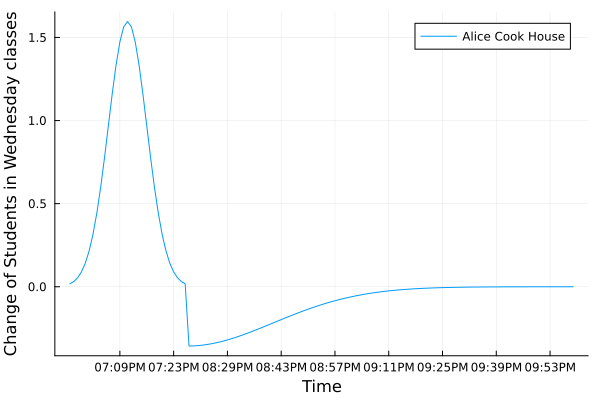

In [35]:
day = "W"
building = "ACH"
plot(distribution_building_Dict_ordered[day][building], xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

In [36]:
distribution_building_Dict_sameTimes = OrderedDict{String,OrderedDict{String,OrderedDict{String,Float64}}}()
for day in keys(distribution_building_Dict_ordered)
    distribution_building_Dict_sameTimes[day] = OrderedDict{String,OrderedDict{String,Float64}}()
    for building in keys(distribution_building_Dict_ordered[day])
        distribution_building_Dict_sameTimes[day][building] = OrderedDict{String,Float64}()
        for time in time_array_busStop
            if !(haskey(distribution_building_Dict_ordered[day][building], time))
                distribution_building_Dict_sameTimes[day][building][time] = 0
            else
                distribution_building_Dict_sameTimes[day][building][time] = distribution_building_Dict_ordered[day][building][time]
            end
        end
    end
end

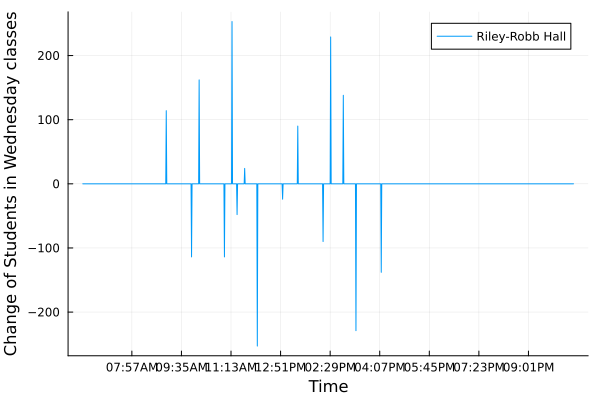

In [37]:
day = "W"
building = "RRB"
plot(time_array_full, y_students_building_change[day][building], xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

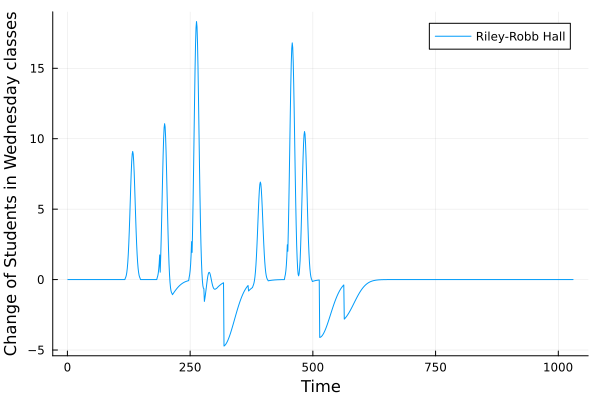

In [38]:
day = "W"
building = "RRB"
y = collect(values(distribution_building_Dict_sameTimes[day][building]))
plot(y, xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

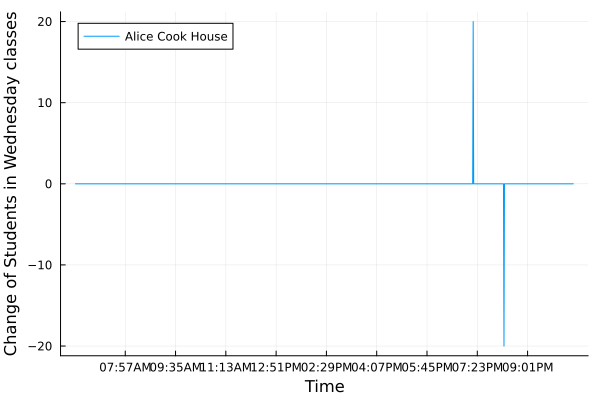

In [39]:
day = "W"
building = "ACH"
plot(time_array_full, y_students_building_change[day][building], xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

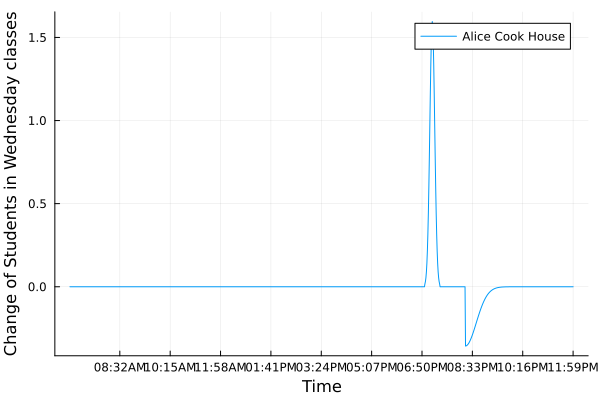

In [40]:
day = "W"
building = "ACH"
# must collect values before plotting, it'll break otherwise
y = collect(values(distribution_building_Dict_sameTimes[day][building]))
plot(time_array_busStop, y, xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

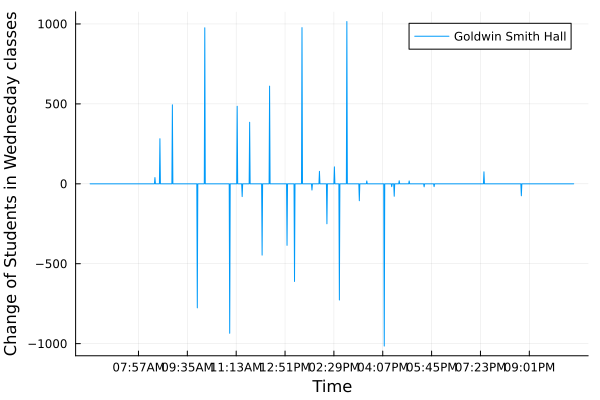

In [41]:
day = "W"
building = "GSH"
plot(time_array_full, y_students_building_change[day][building], xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

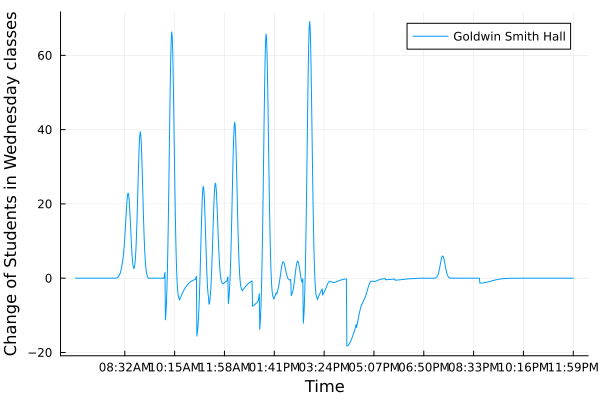

In [42]:
day = "W"
building = "GSH"
# must collect values before plotting, it'll break otherwise
y = collect(values(distribution_building_Dict_sameTimes[day][building]))
plot(time_array_busStop, y, xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

### Put Distributions in terms of bus stops

In [43]:
stop_demand = OrderedDict{Int,OrderedDict{String,Vector{Any}}}()
for stop in 1:9
    stop_demand[stop] = OrderedDict{String,Vector{Any}}()
    for day in keys(distribution_building_Dict_sameTimes)
        stop_demand[stop][day] = zeros(length(time_array_busStop))
        for building in keys(building_stop_dict)
            if building_stop_dict[building] != 0 && building_stop_dict[building] == stop
                building_code = building_name_all_dict[building]
                stop_demand[stop][day] = stop_demand[stop][day] + collect(values(distribution_building_Dict_sameTimes[day][building_code]))
            end
        end
    end
end

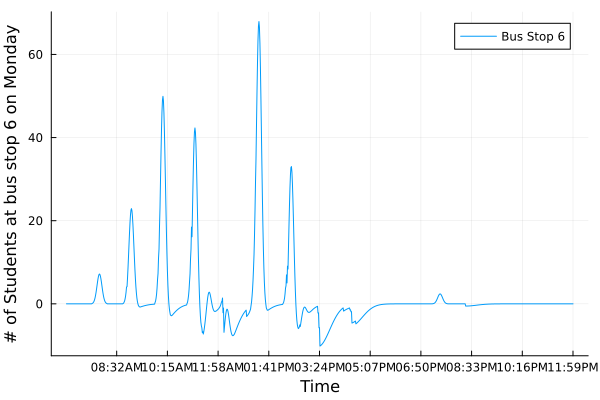

In [44]:
stop = 6
day = "M"
plot(time_array_busStop, stop_demand[stop][day], xlabel="Time", ylabel="# of Students at bus stop $stop on $(days_dict[day])", label="Bus Stop $stop")

In [45]:
# change stop_demand where the time is a dictionary, instead of a vector
stop_demand_Dict = OrderedDict{Int,OrderedDict{String,OrderedDict{String,Float64}}}()
for stop in keys(stop_demand)
    stop_demand_Dict[stop] = OrderedDict{String,OrderedDict{String,Float64}}()
    for day in keys(stop_demand[stop]) # get buildings
        stop_demand_Dict[stop][day] = OrderedDict{String,Float64}()
        for (i, t) in enumerate(time_array_busStop)
            stop_demand_Dict[stop][day][t] = stop_demand[stop][day][i]
        end
    end
end

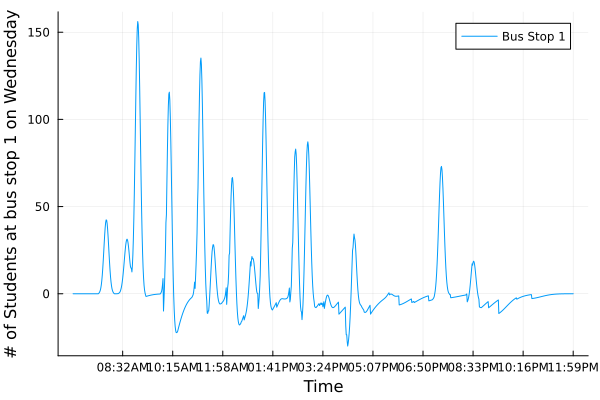

In [46]:
stop = 1
day = "W"
plot(time_array_busStop, collect(values(stop_demand_Dict[stop][day])), xlabel="Time", ylabel="# of Students at bus stop $stop on $(days_dict[day])", label="Bus Stop $stop")

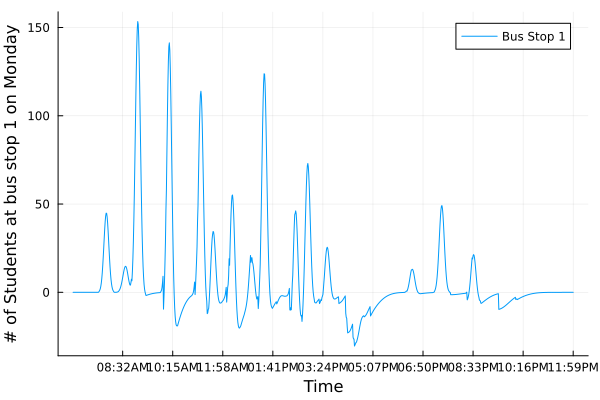

In [47]:
stop = 1
day = "M"
plot(time_array_busStop, collect(values(stop_demand_Dict[stop][day])), xlabel="Time", ylabel="# of Students at bus stop $stop on $(days_dict[day])", label="Bus Stop $stop")

# Export to CSV

### Make values discrete

In [48]:
function convert_to_integers(arr::Vector{Float64})
    result = similar(arr, Int)

    for (i, value) in enumerate(arr)
        if abs(value) <= 0.01
            result[i] = 0
        elseif value > 0
            result[i] = ceil(Int, value)
        elseif value < 0
            result[i] = floor(Int, value)
        end
    end

    return result
end

convert_to_integers (generic function with 1 method)

In [49]:
# change to better format to export as CSV
distribution_building_Dict_dataFrame_discrete = OrderedDict{String, OrderedDict{String, Vector{Any}}}()
distribution_building_Dict_dataFrame = OrderedDict{String, OrderedDict{String, Vector{Any}}}()
for day in keys(distribution_building_Dict_sameTimes)
    distribution_building_Dict_dataFrame[day] = OrderedDict{String, Vector{Any}}()
    distribution_building_Dict_dataFrame_discrete[day] = OrderedDict{String, Vector{Any}}()
    distribution_building_Dict_dataFrame[day]["time"] = time_array_busStop
    distribution_building_Dict_dataFrame_discrete[day]["time"] = time_array_busStop
    for building in keys(distribution_building_Dict_sameTimes[day])
        discrete_array = convert_to_integers(collect(values(distribution_building_Dict_sameTimes[day][building])))
        distribution_building_Dict_dataFrame_discrete[day][building] = discrete_array
        distribution_building_Dict_dataFrame[day][building] = collect(values(distribution_building_Dict_sameTimes[day][building]))
    end
end

In [50]:
# change to better format to export as CSV
stop_demand_Dict_dataFrame_discrete = OrderedDict{Int64, OrderedDict{String, Vector{Any}}}()
stop_demand_Dict_dataFrame = OrderedDict{Int64, OrderedDict{String, Vector{Any}}}()
for stop in keys(stop_demand_Dict)
    stop_demand_Dict_dataFrame[stop] = OrderedDict{Int64, Vector{Any}}()
    stop_demand_Dict_dataFrame[stop]["time"] = time_array_busStop
    stop_demand_Dict_dataFrame_discrete[stop] = OrderedDict{Int64, Vector{Any}}()
    stop_demand_Dict_dataFrame_discrete[stop]["time"] = time_array_busStop
    for day in keys(stop_demand_Dict[stop])
        discrete_array = convert_to_integers(collect(values(stop_demand_Dict[stop][day])))
        stop_demand_Dict_dataFrame_discrete[stop][day] = discrete_array
        stop_demand_Dict_dataFrame[stop][day] = collect(values(stop_demand_Dict[stop][day]))
    end
end

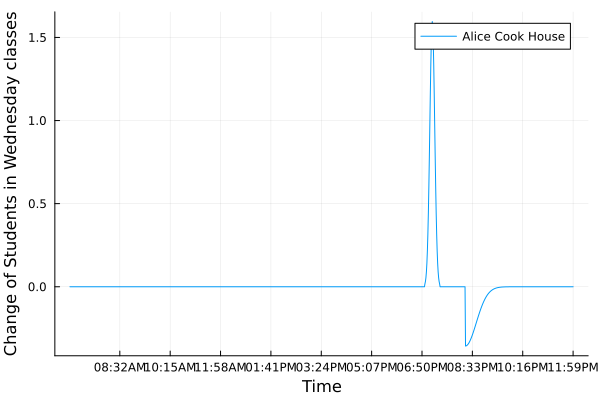

In [51]:
day = "W"
building = "ACH"
# must collect values before plotting, it'll break otherwise
y = collect(values(distribution_building_Dict_dataFrame[day][building]))
plot(time_array_busStop, y, xlabel="Time", ylabel="Change of Students in $(days_dict[day]) classes", label=building_code_dict[building])

In [52]:
function exportCSV_dict(dict, name)
    for key in keys(dict)
        dict[key]["time"] = time_array_busStop
        dict_time = DataFrame(dict[key])
        select!(dict_time, :time, :)
        csv_name = join([name, "$(days_dict[key]).csv"])
        CSV.write(csv_name, dict_time)
        println("Exported ", csv_name)
    end
end

exportCSV_dict (generic function with 1 method)

In [53]:
function exportCSV_dict_busStop(dict, name)
    for key in keys(dict)
        dict[key]["time"] = time_array_busStop
        dict_time = DataFrame(dict[key])
        select!(dict_time, :time, :)
        csv_name = join([name, "$(key).csv"])
        CSV.write(csv_name, dict_time)
        println("Exported ", csv_name)
    end
end

exportCSV_dict_busStop (generic function with 1 method)

In [54]:
function exportCSV(item, name)
    csv_name = join([name, ".csv"])
    item_csv = DataFrame(item)
    CSV.write(csv_name, item_csv)
    println("Exported ", csv_name)
end

exportCSV (generic function with 1 method)

In [55]:
exportCSV_dict(distribution_building_Dict_dataFrame_discrete, "discrete_distributions_")
exportCSV_dict(distribution_building_Dict_dataFrame, "distributions_")

Exported discrete_distributions_Monday.csv
Exported discrete_distributions_Tuesday.csv
Exported discrete_distributions_Wednesday.csv
Exported discrete_distributions_Thursday.csv
Exported discrete_distributions_Friday.csv
Exported discrete_distributions_Saturday.csv
Exported discrete_distributions_Sunday.csv
Exported 

distributions_Monday.csv
Exported distributions_Tuesday.csv
Exported distributions_Wednesday.csv
Exported distributions_Thursday.csv
Exported distributions_Friday.csv
Exported distributions_Saturday.csv
Exported distributions_Sunday.csv


In [56]:
exportCSV(building_code_dict, "building_code")

Exported building_code.csv


In [57]:
exportCSV_dict_busStop(stop_demand_Dict_dataFrame_discrete, "discrete_busStops_")
exportCSV_dict_busStop(stop_demand_Dict_dataFrame, "busStops_")

Exported discrete_busStops_1.csv
Exported discrete_busStops_2.csv
Exported discrete_busStops_3.csv
Exported discrete_busStops_4.csv
Exported discrete_busStops_5.csv
Exported discrete_busStops_6.csv
Exported discrete_busStops_7.csv
Exported discrete_busStops_8.csv
Exported discrete_busStops_9.csv
Exported busStops_1.csv
Exported busStops_2.csv
Exported busStops_3.csv


Exported busStops_4.csv
Exported busStops_5.csv
Exported busStops_6.csv
Exported busStops_7.csv
Exported busStops_8.csv
Exported busStops_9.csv


In [58]:
#exportCSV_dict(y_students_building, "students_building_")
#exportCSV_dict(y_students_building_change, "students_building_change_")